# **Shakespeare-Style Text Generation with DistilGPT2**

This notebook demonstrates the implementation of a Causal Language Model for generating text in the style of Shakespeare, using the pre-trained [DistilGPT2 (short for Distilled-GPT2)](https://huggingface.co/distilbert/distilgpt2) model from [Hugging Face 🤗](https://huggingface.co/). In this case, the dataset is expanded with a larger one compared to the one used in the [LSTM model](https://github.com/JersonGB22/CausalLanguageModeling-TensorFlow/blob/main/models_lstm/CausalLM_LSTM_Shakespeare.ipynb). This dataset is obtained from the official [Project Gutenberg](https://www.gutenberg.org/cache/epub/100/pg100.txt) page and contains the most important works of Shakespeare.

Hugging Face is a platform focused on developing tools and models for natural language processing (NLP). It is known for its open-source library called Transformers, which provides an easy-to-use interface for working with advanced pre-trained NLP models like BERT, T5, GPT, and others.

**Key Points:**
- **Model Architecture:** The DistilGPT2 model, the smaller version of Generative Pre-trained Transformer 2 (GPT-2), pre-trained in English, is fine-tuned using a causal language modeling (CLM) objective and has 82 million parameters. The model is loaded using the generic [TFAutoModelForCausalLM](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.TFAutoModelForCausalLM) class, which allows creating an instance of a pre-trained TensorFlow-based model designed specifically for causal language tasks as it includes an appropriate classification layer on top. This differs from [TFAutoModel](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel), which provides the base model without additional layers.

- **Tokenization:** Hugging Face has implemented a tokenizer for each of its models that returns everything needed for the respective model's inputs. In this case, the generic tokenizer [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) will be used, which allows creating an instance of the model's tokenizer by its name alone. For this text generation task, the entire text is tokenized, returning `input_ids` (the tokenized sequences) and `attention_mask` (a mask to avoid attending to padding token indices), and then split into blocks of size `seq_length` to be fed into the model.

- **Use of TPU:** In this case, it is not strictly necessary to use a Google Colab TPU since the model and dataset are small and a GPU could be used. However, using a TPU significantly accelerates the training time.

For an implementation with a larger model, visit my next [notebook](https://github.com/JersonGB22/CausalLanguageModeling-TensorFlow/blob/main/models_transformers/CausalLM_GPT2_WikiText-103.ipynb), where a GPT-2 model is fine-tuned with the WikiText-103 dataset.

## **Imports**

In [1]:
import tensorflow as tf
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

from transformers import TFAutoModelForCausalLM, AutoTokenizer
import numpy as np
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML

## **Parameters**

In [2]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
model_name = "distilgpt2"
seq_length = 256
batch_size = 32
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
epochs = 20

## **Load and Preprocess the Dataset**

In [ ]:
# Dictionary containing all of Shakespeare's works present in the text
contents = {
    "THE SONNETS": "",
    "ALL'S WELL THAT ENDS WELL": "",
    "THE TRAGEDY OF ANTONY AND CLEOPATRA": "",
    "AS YOU LIKE IT": "",
    "THE COMEDY OF ERRORS": "",
    "THE TRAGEDY OF CORIOLANUS": "",
    "CYMBELINE": "",
    "THE TRAGEDY OF HAMLET, PRINCE OF DENMARK": "",
    "THE FIRST PART OF KING HENRY THE FOURTH": "",
    "THE SECOND PART OF KING HENRY THE FOURTH": "",
    "THE LIFE OF KING HENRY THE FIFTH": "",
    "THE FIRST PART OF HENRY THE SIXTH": "",
    "THE SECOND PART OF KING HENRY THE SIXTH": "",
    "THE THIRD PART OF KING HENRY THE SIXTH": "",
    "KING HENRY THE EIGHTH": "",
    "THE LIFE AND DEATH OF KING JOHN": "",
    "THE TRAGEDY OF JULIUS CAESAR": "",
    "THE TRAGEDY OF KING LEAR": "",
    "LOVE'S LABOUR'S LOST": "",
    "THE TRAGEDY OF MACBETH": "",
    "MEASURE FOR MEASURE": "",
    "THE MERCHANT OF VENICE": "",
    "THE MERRY WIVES OF WINDSOR": "",
    "A MIDSUMMER NIGHT'S DREAM": "",
    "MUCH ADO ABOUT NOTHING": "",
    "THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE": "",
    "PERICLES, PRINCE OF TYRE": "",
    "KING RICHARD THE SECOND": "",
    "KING RICHARD THE THIRD": "",
    "THE TRAGEDY OF ROMEO AND JULIET": "",
    "THE TAMING OF THE SHREW": "",
    "THE TEMPEST": "",
    "THE LIFE OF TIMON OF ATHENS": "",
    "THE TRAGEDY OF TITUS ANDRONICUS": "",
    "TROILUS AND CRESSIDA": "",
    "TWELFTH NIGHT; OR, WHAT YOU WILL": "",
    "THE TWO GENTLEMEN OF VERONA": "",
    "THE TWO NOBLE KINSMEN": "",
    "THE WINTER'S TALE": "",
    "A LOVER'S COMPLAINT": "",
    "THE PASSIONATE PILGRIM": "",
    "THE PHOENIX AND THE TURTLE": "",
    "THE RAPE OF LUCRECE": "",
    "VENUS AND ADONIS": "",
    "FINIS": "" #Key added to mark the completion of all works
}

In [ ]:
# Download the dataset
dataset_path = tf.keras.utils.get_file(
    fname="shakespeare.txt",
    origin="https://www.gutenberg.org/cache/epub/100/pg100.txt"
)

# Read the dataset
lines_text = []
with open(dataset_path, "r") as file:
  for line in file:
    # Remove excessive line breaks and whitespace
    line = line.strip()
    if line:
      # Replace the typographic apostrophe with the straight one to standardize the text
      lines_text.append(line.replace("’", "'"))

# Fill the values of 'contents' with the starting indices of each work
keys = list(contents.keys())
for k in range(len(keys)):
  id_start = [i for i, line in enumerate(lines_text) if keys[k] in line][-1]
  if k < len(keys) - 1:
    id_end = [i for i, line in enumerate(lines_text) if keys[k+1] in line][-1]
  else:
    id_end = id_start + 1

  contents[keys[k]] = (id_start, id_end)

# In this case, all of Shakespeare's works are taken
line_start = contents["THE SONNETS"][0]
line_end = contents["FINIS"][1]
lines_text = lines_text[line_start:line_end]

# View an excerpt of Shakespeare's text
print(f"Total lines in the text: {len(lines_text)}\n")
print(f"Some lines:\n{lines_text[:5]}\n{lines_text[-5:]}\n\n")

# View an excerpt of Shakespeare's text
example = "\n".join(lines_text[:20]) # Join the lines into a single text
print(f"Text Extract:\n\n{example}")

Total lines in the text: 153571

Some lines:
['THE SONNETS', '1', 'From fairest creatures we desire increase,', "That thereby beauty's rose might never die,", 'But as the riper should by time decease,']
['Their mistress mounted through the empty skies,', "In her light chariot quickly is convey'd;           1192", 'Holding their course to Paphos, where their queen', 'Means to immure herself and not be seen.', 'FINIS']


Text Extract:

THE SONNETS
1
From fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed'st thy light's flame with self-substantial fuel,
Making a famine where abundance lies,
Thyself thy foe, to thy sweet self too cruel:
Thou that art now the world's fresh ornament,
And only herald to the gaudy spring,
Within thine own bud buriest thy content,
And, tender churl, mak'st waste in niggarding:
Pity the world, or else t

### **Text Tokenization**

In [5]:
# 'use_fast=True': improves the tokenizer's performance when processing large volumes of text
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer

GPT2TokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [ ]:
# Example of tokenization

encoding = tokenizer(example)

input_ids = encoding["input_ids"]
print("Input Ids:\n", input_ids, "\n")
print("Tokens:\n", tokenizer.convert_ids_to_tokens(input_ids), "\n")
print(f"Decoded Text:\n{tokenizer.decode(input_ids)}\n\n")

print("Attention Mask:\n", encoding["attention_mask"])

Input Ids:
 [10970, 311, 1340, 12884, 50, 198, 16, 198, 4863, 37063, 301, 8109, 356, 6227, 2620, 11, 198, 2504, 12839, 8737, 338, 8278, 1244, 1239, 4656, 11, 198, 1537, 355, 262, 374, 9346, 815, 416, 640, 12738, 589, 11, 198, 6653, 15403, 28625, 1244, 6842, 465, 4088, 25, 198, 1537, 14210, 23407, 284, 294, 500, 898, 6016, 2951, 11, 198, 18332, 338, 83, 11906, 1657, 338, 16506, 351, 2116, 12, 7266, 41321, 5252, 11, 198, 23874, 257, 31261, 810, 20038, 7363, 11, 198, 817, 88, 944, 11906, 22156, 11, 284, 11906, 6029, 2116, 1165, 12177, 25, 198, 817, 280, 326, 1242, 783, 262, 995, 338, 4713, 45618, 11, 198, 1870, 691, 28783, 284, 262, 308, 3885, 88, 6076, 11, 198, 22005, 294, 500, 898, 3600, 4356, 6386, 11906, 2695, 11, 198, 1870, 11, 15403, 442, 6371, 11, 285, 461, 338, 83, 7030, 287, 299, 6950, 13493, 25, 198, 47, 414, 262, 995, 11, 393, 2073, 428, 1278, 21115, 307, 11, 198, 2514, 4483, 262, 995, 338, 2233, 11, 416, 262, 12296, 290, 17903, 13, 198, 17, 198, 2215, 16571, 45764, 2236, 7284,

### **Create the Training and Evaluation Datasets**

In this case, it is not necessary to convert the datasets to the TFRecord format since both the dataset and the model are small. It is sufficient to convert it to the `tf.data.Dataset.from_tensor_slices` format.

In [ ]:
def create_datasets(lines_text, val_size=0.1):
  def split_input_label(input_ids, attention_mask):
    inputs = input_ids[:-1]
    labels = input_ids[1:] #The 'labels' are simply the 'ids' shifted one position to the right
    return (inputs, attention_mask[:-1]), labels

  N = int(len(lines_text) * val_size)
  train_dataset = "\n".join(lines_text[:-N])
  val_dataset = "\n".join(lines_text[-N:])
  train_dataset = tokenizer(train_dataset)
  val_dataset = tokenizer(val_dataset)

  train_dataset = tf.data.Dataset.from_tensor_slices(
      (train_dataset["input_ids"], train_dataset["attention_mask"])
  )
  val_dataset = tf.data.Dataset.from_tensor_slices(
      (val_dataset["input_ids"], val_dataset["attention_mask"])
  )
  train_dataset = train_dataset.batch(seq_length + 1, drop_remainder=True)
  val_dataset = val_dataset.batch(seq_length + 1, drop_remainder=True)

  train_dataset = (
      train_dataset.
      map(split_input_label).
      shuffle(buffer_size, seed=SEED).
      batch(batch_size).
      prefetch(AUTOTUNE)
  )

  val_dataset = (
      val_dataset.
      map(split_input_label).
      batch(batch_size).
      prefetch(AUTOTUNE)
  )

  return train_dataset, val_dataset

In [ ]:
train_dataset, val_dataset = create_datasets(lines_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (1426710 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
# Viewing a training batch
for (ids, masks), labels in train_dataset.take(1):
  print(ids, "\n")
  print(masks, "\n")
  print(labels)

tf.Tensor(
[[  284   326   886 ...  1581 28182    46]
 [11633  1683  1842 ...   314  1183  1085]
 [  673  2921 17903 ...   815   326  8737]
 ...
 [ 1169  1944  4167 ...   683    13   198]
 [ 2937    13   198 ...   286   428    13]
 [ 3963 19704    49 ...   198  1890   644]], shape=(32, 256), dtype=int32) 

tf.Tensor(
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]], shape=(32, 256), dtype=int32) 

tf.Tensor(
[[  326   886 13750 ... 28182    46    13]
 [ 1683  1842   523 ...  1183  1085   345]
 [ 2921 17903   517 ...   326  8737   543]
 ...
 [ 1944  4167    11 ...    13   198 17469]
 [   13   198 22788 ...   428    13   632]
 [19704    49  2246 ...  1890   644  1738]], shape=(32, 256), dtype=int32)


## **Creation and Training of the Model**

In [ ]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except ValueError:
  print("TPU not found")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
# Callback to stop training early if validation loss does not decrease for 2 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    mode="min",
    restore_best_weights=True
)

In [ ]:
def create_model():
  # Import the AutoModel
  model_base = TFAutoModelForCausalLM.from_pretrained(model_name)

  input_ids = tf.keras.Input((seq_length, ), dtype=tf.int32)
  attention_mask = tf.keras.Input((seq_length, ), dtype=tf.int32)
  logits = model_base(input_ids=input_ids, attention_mask=attention_mask).logits

  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=logits)

  return model

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

# Creation and compilation of the model within the distribution strategy
with strategy.scope():
  model = create_model()

  model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 tfgpt2lm_head_model (TFGPT  TFCausalLMOutputWithCrossA   8191257   ['input_1[0][0]',             
 2LMHeadModel)               ttentions(loss=None, logit   6          'input_2[0][0]']             
                             s=(None, 256, 50257),                                                
                              past_key_values=((2, None                                       

In [ ]:
# Example of prediction before training the model

pred_example = model.predict((ids[0][None, :], masks[0][None, :]), verbose=0)[0]
pred_example = np.argmax(pred_example, axis=-1)
tokenizer.decode(pred_example)

' The�.hip.\n/ by\n the� too wife, and the from the\n a. and I sake\n I brother are the wayceorn are\n\n asless be as he am\nI,, is is has muchifully\n to, he\n whichthat he is me,\nenance, to me him him,\n is me knownot him him own legs, and, with way of the\n, and\n much as I histhe, in he me wayleness, his own.\n is the, and,\n\nthativesves me, and I thing of his life, and\n\n\n the him.\nandgan to beter, him\nile.\n am not longer be this, andand I I will that more man. to make it.\nAnd the,\nIV\n\nIours, to way, and master,\nIIGO.\nI to and and. and I shalt not the I is\n me..\nAnd]]ires]]\nIIVER.\nI, I,\n is you think?\nILANDO.\nGo is\n am not a to do a,\nIIVER.\nI dories,? is?\nORLANDO.'

It can be observed that before fine-tuning the model, the generated text is not completely random.

In [ ]:
# Train the model

tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/20
174/174 [==============================] - 118s 315ms/step - loss: 4.1207 - val_loss: 4.0907
Epoch 2/20
174/174 [==============================] - 17s 98ms/step - loss: 3.8803 - val_loss: 4.0205
Epoch 3/20
174/174 [==============================] - 18s 99ms/step - loss: 3.7789 - val_loss: 3.9807
Epoch 4/20
174/174 [==============================] - 17s 98ms/step - loss: 3.7100 - val_loss: 3.9568
Epoch 5/20
174/174 [==============================] - 17s 97ms/step - loss: 3.6585 - val_loss: 3.9366
Epoch 6/20
174/174 [==============================] - 17s 99ms/step - loss: 3.6167 - val_loss: 3.9200
Epoch 7/20
174/174 [==============================] - 17s 98ms/step - loss: 3.5807 - val_loss: 3.9033
Epoch 8/20
174/174 [==============================] - 18s 99ms/step - loss: 3.5498 - val_loss: 3.8951
Epoch 9/20
174/174 [==============================] - 17s 98ms/step - loss: 3.5220 - val_loss: 3.8890
Epoch 10/20
174/174 [==============================] - 17s 98ms/step - loss: 3.4

**Save model**

In [6]:
trained_model_path = "/content/drive/MyDrive/models/CausalLM_DistilGPT2_Shakespeare"

In [ ]:
model.layers[2].save_pretrained(trained_model_path)

## **Model Evaluation**

In [ ]:
loss_train = model.evaluate(train_dataset, verbose=0)
loss_val = model.evaluate(val_dataset, verbose=0)
print(f"Training Dataset:\nLoss: {loss_train}\tPerplexity: {np.exp(loss_train)}\n")
print(f"Validation Dataset:\nLoss: {loss_val}\tPerplexity: {np.exp(loss_val)}")

Training Dataset:
Loss: 3.1728694438934326	Perplexity: 23.87589670278736

Validation Dataset:
Loss: 3.8304426670074463	Perplexity: 46.08293311390714


In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics()

**Images for GitHub**

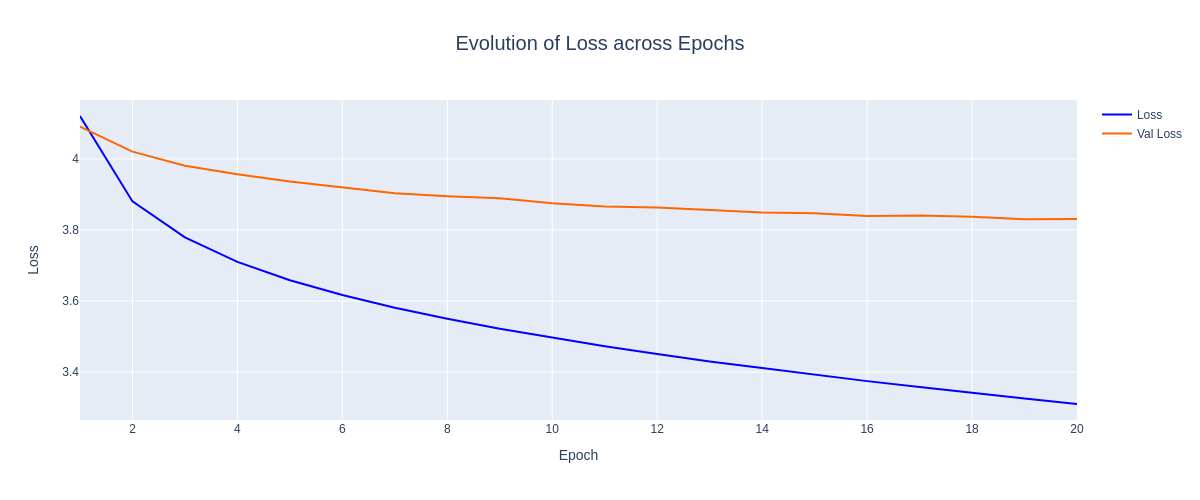

In [ ]:
plot_metrics(renderer="png")

## **Text Generation with the Trained Model**

In [9]:
# Load the trained model
tf.keras.backend.clear_session()
model = TFAutoModelForCausalLM.from_pretrained(trained_model_path)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/models/CausalLM_DistilGPT2_Shakespeare.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


For text generation, Sampling methods such as top-p and top-K are often more effective than Greedy and Beam Search methods, as noted in the following [Hugging Face article](https://huggingface.co/blog/how-to-generate), to produce more natural text and reduce repetitions. Additionally, maintaining text coherence requires crucial adjustment of the ``softmax temperature``. To prevent excessive word repetitions, it is also important to properly configure the n-grams penalty parameter (``no_repeat_ngram_size``). Therefore, in this case, the following parameter values are considered optimal for generating text in the style of Shakespeare:

```
- temperature = 0.85
- top_k = 100
- top_p = 0.9
- no_repeat_ngram_size = 3
```

In [ ]:
def generate_text(prefix=" ", num_tokens=100, temperature=0.85):
  inputs = tokenizer(prefix, return_tensors="tf")

  preds = model.generate(
      **inputs,
      max_length=num_tokens,
      do_sample=True, #Activates Sampling for text generation
      temperature=temperature,
      top_k=100,
      top_p=0.9,
      no_repeat_ngram_size=3
  )

  preds = tokenizer.decode(preds[0])
  #Replace '\n' with '<br>' to make the line break visible in HTML format
  preds = preds.replace("\n", "<br>")
  # Shade the prefix in yellow
  preds = f"<span style='background-color: yellow;'>{preds[:len(prefix)]}</span>{preds[len(prefix):]}"

  display(HTML(f"<b>GENERATED TEXT:</b><br><br>{preds}"))

In [ ]:
generate_text(prefix="King", num_tokens=200)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
generate_text(
    prefix="Enter, with flourish, the Duke of",
    num_tokens=250
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
generate_text(
    prefix="O brave new world,",
    num_tokens=350
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
generate_text(
    prefix="Fair ladies and noble lords,",
    num_tokens=500,
    temperature=0.5
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
generate_text(
    prefix="On this stage,",
    num_tokens=350
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**Conclusion:** The fine-tuned DistilGPT2 model demonstrates a significant improvement in text generation compared to the LSTM model. Coherence, fluency, grammar, and adherence to style are noticeably superior, suggesting that using transformer-based architectures and larger datasets leads to better results in text generation tasks. However, text generation could further benefit from selecting works of specific genres of Shakespeare, such as drama, comedy, or tragedy. This would allow the model to more accurately capture the unique stylistic characteristics of each genre, compared to training on all works, which may result in less coherent and less fluent text due to improper generalization. Additionally, text generation could be enhanced by using more robust models such as GPT-2 Medium, GPT-2 Large, or GPT-2 XL.